In [1]:
import json
import tensorflow as tf
from tensorflow.keras import Input
import numpy as np
import pandas as pd
import pickle
from sklearn.model_selection import train_test_split
from tensorflow.keras.layers import Input, Dense, Concatenate, Dropout, BatchNormalization, LSTM
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping

# Configuring TensorFlow to use GPU
physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


#### Datasets

In [2]:
x_train_cell_lines = pd.read_csv('../data/splits/train/x_train_cell_lines.csv', index_col=0)
x_train_drugs = pd.read_csv('../data/splits/train/x_train_drugs.csv', index_col=0)
y_train = pd.read_csv('../data/splits/train/y_train.csv', index_col=0)

x_test_cell_lines = pd.read_csv('../data/splits/test/x_test_cell_lines.csv', index_col=0)
x_test_drugs = pd.read_csv('../data/splits/test/x_test_drugs.csv', index_col=0)
y_test = pd.read_csv('../data/splits/test/y_test.csv', index_col=0)

x_val_cell_lines = pd.read_csv('../data/splits/val/x_val_cell_lines.csv', index_col=0)
x_val_drugs = pd.read_csv('../data/splits/val/x_val_drugs.csv', index_col=0)
y_val = pd.read_csv('../data/splits/val/y_val.csv', index_col=0)

### Merge data

In [3]:
# transform smiles to fingerprints
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit.Chem import MACCSkeys

def smiles_to_fingerprint(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits=1024)
    return fp

def smiles_to_maccs(smiles):
    mol = Chem.MolFromSmiles(smiles)
    fp = MACCSkeys.GenMACCSKeys(mol)
    return fp

x_train_drugs['Drug'] = x_train_drugs['Drug'].apply(smiles_to_fingerprint)
x_test_drugs['Drug'] = x_test_drugs['Drug'].apply(smiles_to_fingerprint)
x_val_drugs['Drug'] = x_val_drugs['Drug'].apply(smiles_to_fingerprint)

In [4]:
x_train_drugs

,Drug
Dabrafenib_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, ..."
Lapatinib_TGW,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, ..."
Ruxolitinib_GCT,"[0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
MN-64_EW-24,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Sapitinib_NCI-H1869,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
...,...
PFI3_SW1463,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
I-BRD9_SW1710,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Olaparib_RERF-GC-1B,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
Crizotinib_HCC2218,"[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."


In [5]:
x_train_drugs = pd.concat([x_train_drugs.drop(['Drug'], axis=1), x_train_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_test_drugs = pd.concat([x_test_drugs.drop(['Drug'], axis=1), x_test_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)
x_val_drugs = pd.concat([x_val_drugs.drop(['Drug'], axis=1), x_val_drugs['Drug'].apply(lambda x: pd.Series({f'fp{str(i)}': val for i, val in enumerate(x)}))], axis=1)

In [6]:
y_train

,Y
Dabrafenib_SW1710,5.419252
Lapatinib_TGW,3.301479
Ruxolitinib_GCT,3.817540
MN-64_EW-24,5.871297
Sapitinib_NCI-H1869,2.456632
...,...
PFI3_SW1463,5.684813
I-BRD9_SW1710,4.154810
Olaparib_RERF-GC-1B,4.386607
Crizotinib_HCC2218,4.622847


### Dense model ###

In [7]:
from models import DenseModel


# Example usage

model = DenseModel(x_train_cell_lines.values.shape[1], x_train_drugs.values.shape[1],expr_hlayers_sizes='[625, 312]', drug_hlayers_sizes='[1000, 500, 250]',predictor_hlayers_sizes='[1000]', hidden_dropout=0.3, optimizer='Adam', learn_rate=0.0001)
print(model.summary())
model.train(x_train_cell_lines.values, x_train_drugs.values, y_train.values, epochs=100, batch_size=126)

val_loss, val_mae = model.evaluate(x_val_cell_lines.values, x_val_drugs.values, y_val.values)
print(f'Test Loss: {val_loss}, Test MAE: {val_mae}')

predictions = model.predict(x_test_cell_lines.values, x_test_drugs.values)
print(predictions)


Skipped loading some PyTorch models, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-geometric dependency, missing a dependency. No module named 'torch'
Skipped loading modules with pytorch-lightning dependency, missing a dependency. No module named 'torch'
Skipped loading some Jax models, missing a dependency. No module named 'jax'


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cell_line_input (InputLayer)   [(None, 2089)]       0           []                               
                                                                                                  
 drug_input (InputLayer)        [(None, 1024)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 10)           20900       ['cell_line_input[0][0]']        
                                                                                                  
 dense_1 (Dense)                (None, 10)           10250       ['drug_input[0][0]']             
                                                                                              

c:\Users\Paulo Seixal\anaconda3\envs\drug39\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:114: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


None
Epoch 1/100
351/351 [==============================] - 6s 11ms/step - loss: 8.8596 - mae: 2.4608 - val_loss: 5.1168 - val_mae: 1.8943
Epoch 2/100
351/351 [==============================] - 3s 8ms/step - loss: 3.8366 - mae: 1.5477 - val_loss: 2.0803 - val_mae: 1.1024
Epoch 3/100
351/351 [==============================] - 3s 8ms/step - loss: 2.8880 - mae: 1.3178 - val_loss: 1.9076 - val_mae: 1.0488
Epoch 4/100
351/351 [==============================] - 3s 8ms/step - loss: 2.5999 - mae: 1.2506 - val_loss: 1.7142 - val_mae: 0.9752
Epoch 5/100
351/351 [==============================] - 3s 8ms/step - loss: 2.4302 - mae: 1.2071 - val_loss: 1.6265 - val_mae: 0.9515
Epoch 6/100
351/351 [==============================] - 3s 8ms/step - loss: 2.3043 - mae: 1.1712 - val_loss: 1.6459 - val_mae: 0.9671
Epoch 7/100
351/351 [==============================] - 3s 8ms/step - loss: 2.1672 - mae: 1.1353 - val_loss: 1.5570 - val_mae: 0.9211
Epoch 8/100
351/351 [==============================] - 3s 9ms/s

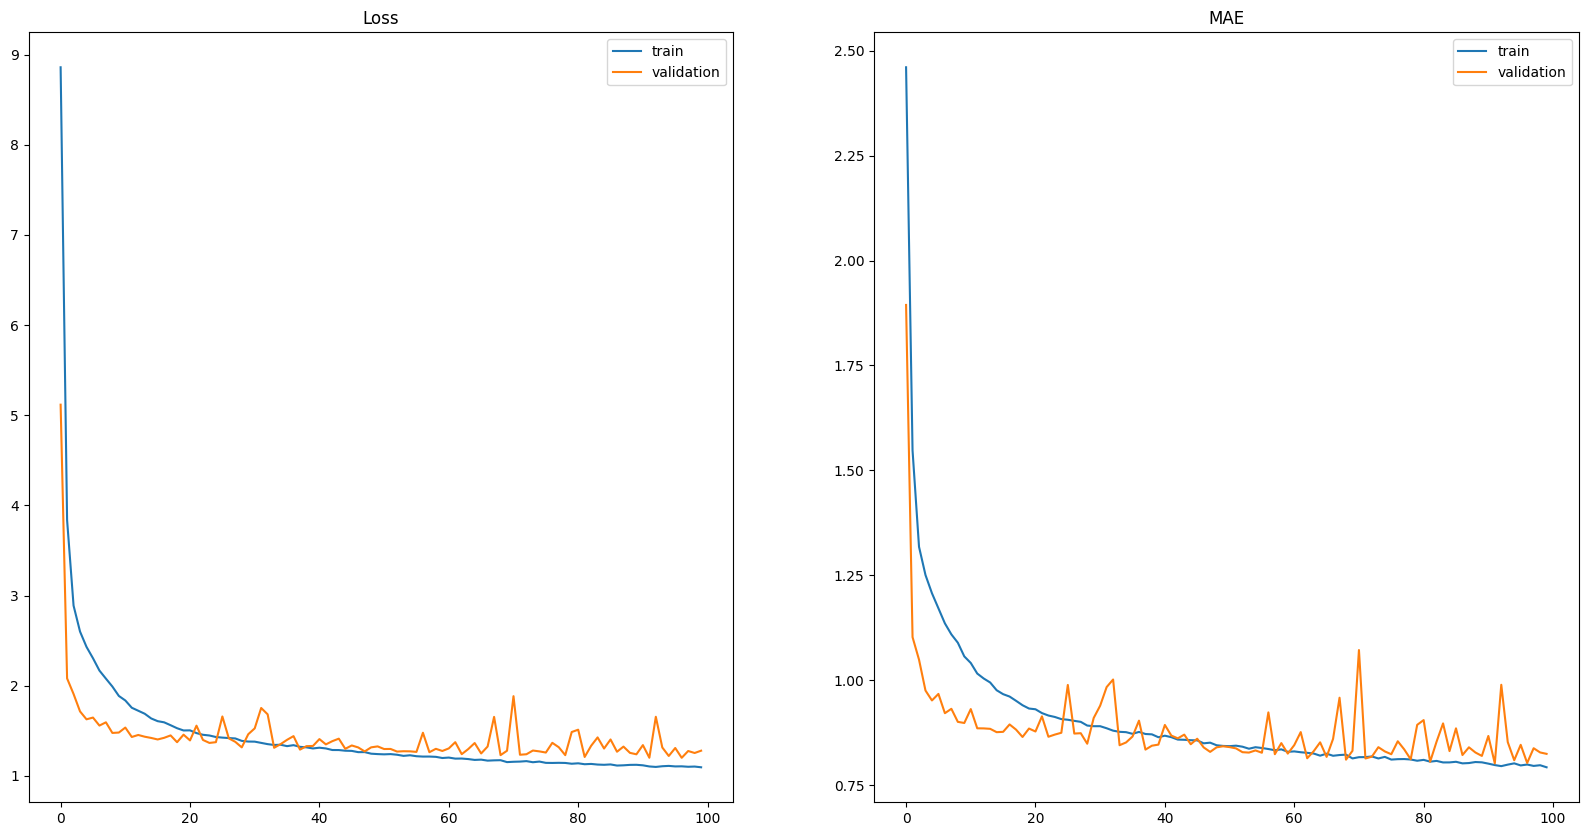

In [12]:
#plot loss and mae from training and validation data side by side
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 10))
plt.subplot(1, 2, 1)
plt.plot(model.history.history['loss'], label='train')
plt.plot(model.history.history['val_loss'], label='validation')
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(model.history.history['mae'], label='train')
plt.plot(model.history.history['val_mae'], label='validation')
plt.title('MAE')
plt.legend()
plt.show()





In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


print('Dense model')
print('MAE: ', mean_absolute_error(y_test, predictions))
print('MSE: ', mean_squared_error(y_test, predictions))
print('RMSE: ', np.sqrt(mean_squared_error(y_test, predictions)))
print('R2: ', r2_score(y_test, predictions))

Dense model
MAE:  0.8205588828460643
MSE:  1.2131427674744
RMSE:  1.1014276042820064
R2:  0.8401380331223864
